# Relating Neural Firing to Stimuli

## 1 Preparation

Import the modules required for this session

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
%matplotlib inline

Download the data required for this session

In [2]:
import requests

urls = [
    "https://uni-bonn.sciebo.de/s/G64EkHoQkeZeoLm",
    "https://uni-bonn.sciebo.de/s/mLMkb2TwbNx3Yg6",
]
fnames = ["flash_stimuli.parquet", "flash_spikes.parquet"]

for url, fname in zip(urls, fnames):
    response = requests.get(f"{url}/download")
    print("Downloading Data ...")
    with open(fname, "wb") as file:
        file.write(response.content)
    print("Done!")

## 2 Referencing Spike Times to Stimulus Presentations

In many experiments, we wish to relate neural spiking to external
events, like stimuli. This requires that we can relate the timing of the
spikes to the timing of the events. If both spikes and stimuli are
stored in data frames, we an use pandas’ `merge_asof` function to merge
the time information from both data frames. In this section, we are
going to explore how to use pandas to compute the timing of spikes
relative to stimulus onset. Then, we’ll visualize the amount of spikes
ocurring right before and after a stimulus in a peri-stimulus time
histogram or PSTH.

| Code | Description |
|------------------------------------|------------------------------------|
| `df = pd.read_parquet(mydata.parquet)` | Read the file `"mydata.parquet"` into a data frame |
| `pd.merge_asof(left, right, left_on, right_on)` | Merge data frames `left` and `right` based on the columns `left_on` and `right_on` |
| `df["newcol"] = values` | Add a new column named `"newcol"` to `df` and assign it the `values` |
| `df.col1.min()` | Get the minimum value of `"col1"` |
| `df[df.col1<1]` | Get all rows of `df` where the value of `"col1"` is smaller than 1 |
| `sns.histplot(df, x="col1", hue="col2")` | Plot a histogram of the values in `"col1"` and add a `hue` for the categories in `"col2"` |
| `sns.histplot(df, x="col1", bins=n)` | Plot a histogram of the values in `"col1"` with `n` bins |
| `plt.axvline(x, ymin, ymax)` | Add a vertical line at `x` that goes from `ymin` to `ymax` |
| `plt.xlim(xmin, xmax)` | Limit the x-axis to the range between `xmin` and `xmax` |

------------------------------------------------------------------------

<span class="theorem-title">**Exercise 1**</span> Load the data stored
in the files `"flash_spikes.parquet"` and `"flash_stimuli.parquet"` into
data frames and assign them to variables called `spikes` and `stimuli`.

*Solution.*

In [3]:
spikes = pd.read_parquet("flash_spikes.parquet")
stimuli = pd.read_parquet("flash_stimuli.parquet")

<span class="theorem-title">**Example 1**</span> Use `pd.merge_asof()`
to merge the `spikes` and `stimuli` based on the `"spike_time"` and
`"start_time"`. In the resulting `df`, each spike is paired with the
last stimulus that was presented before that spike.

In [5]:
df = pd.merge_asof(spikes, stimuli, left_on="spike_time", right_on="start_time")
df

457706 rows × 5 columns

<span class="theorem-title">**Exercise 2**</span> Subtract the stimulus
`.start_time` column from the `.spike_time` column to get the spike
times relative to stimulus onset. Then, print the smallest spike time in
`df`.

*Solution.*

In [6]:
df.spike_time = df.spike_time - df.start_time
df.spike_time.min()

2.332144799765956e-05

<span class="theorem-title">**Exercise 3**</span> The smallest spike
time should be very close to 0. However, we would like our analysis time
window to include spikes that happen before the stimulus as well. Add a
new column to `stimuli` called `"analysis_window_start"` that is equal
to the stimulus `"start_time"` minus `0.5` seconds. Print the `stimuli`
to make sure the new column was created.

*Solution.*

In [8]:
stimuli["analysis_window_start"] = stimuli["start_time"] - 0.5
stimuli

75 rows × 3 columns

<span class="theorem-title">**Exercise 4**</span> Use `pd.merge_asof()`
with `right_on="analysis_window_start"` to match each spike with the
analysis window that started before it.

*Solution.*

In [10]:
df = pd.merge_asof(
    spikes, stimuli, left_on="spike_time", right_on="analysis_window_start"
)
df

457706 rows × 6 columns

<span class="theorem-title">**Exercise 5**</span> Subtract the stimulus
`.start_time` column from the `.spike_time` column to get the spike
times relative to stimulus onset. Then, print the smallest spike time in
`df` this value should be very close to `-0.5`.

*Solution.*

In [12]:
df.spike_time = df.spike_time - df.start_time
df.spike_time.min()

-0.4999979524416176

<span class="theorem-title">**Exercise 6**</span> Remove all the the
rows in `df` where the `"spike_time"` relative to stimulus onset is
greater than `1` second and print the maximum spike time.

*Solution.*

In [14]:
df = df[df.spike_time <= 1]
df.spike_time.max()

0.9999981341300099

<span class="theorem-title">**Exercise 7**</span> Use `sns.histplot` to
create a histogram of spike times relative to stimulus onset.

*Solution.*

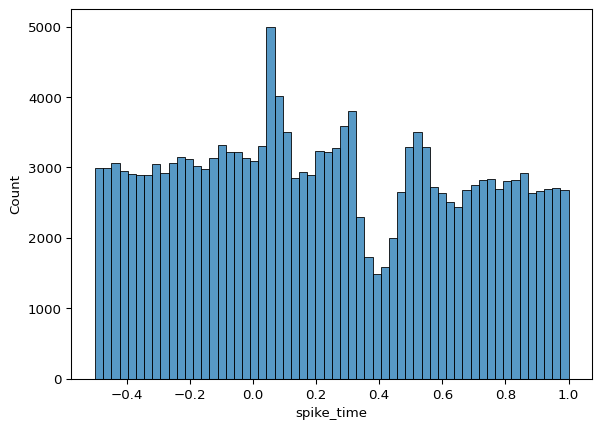

In [16]:
sns.histplot(df, x="spike_time")

<span class="theorem-title">**Exercise 8**</span> Use `sns.histplot` to
create a histogram of spike times and use `plt.axvline()` to add
vertical lines that mark the stimulus onset at `0` seconds and the
offset at `0.25` seconds (BONUS): try using `color="black"` and
`linestyle="--"` to make them look nice). Can you see the relationship
between the spiking and stimuli?

*Solution.*

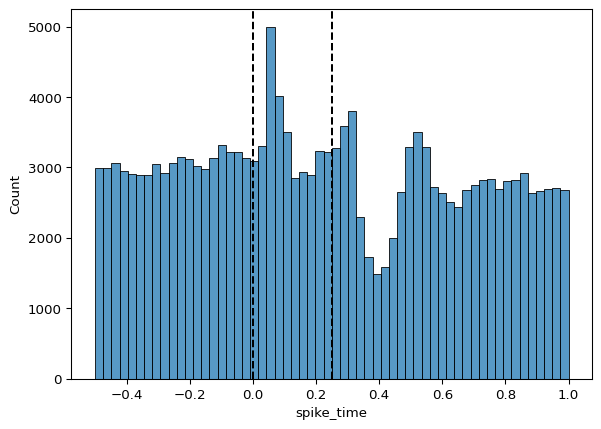

In [18]:
sns.histplot(df, x="spike_time")
plt.axvline(x=0, ymin=0, ymax=1, color="black", linestyle='--')
plt.axvline(x=0.25, ymin=0, ymax=1, color="black", linestyle='--')

<span class="theorem-title">**Exercise 9**</span> Add a `hue` to the
histogram that encodes the `"brain_area"`.

*Solution.*

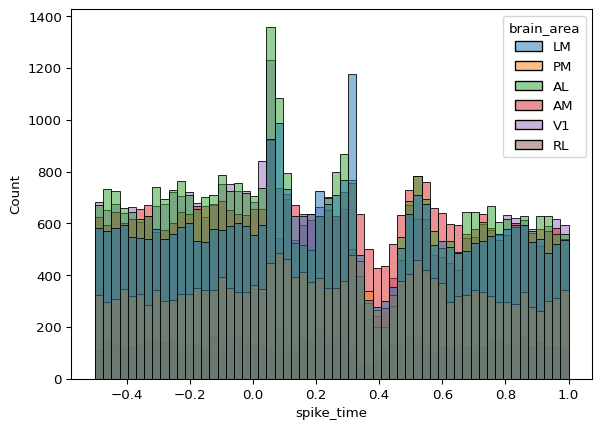

In [20]:
sns.histplot(df, x="spike_time", hue="brain_area")

<span class="theorem-title">**Exercise 10**</span> Increate the number
of `bins` in the histogram to improve the temporal resolution and limit
the x-axis to the first `0.15` second after stimulus onset. Can you see
which brain area responds first?

*Solution.*

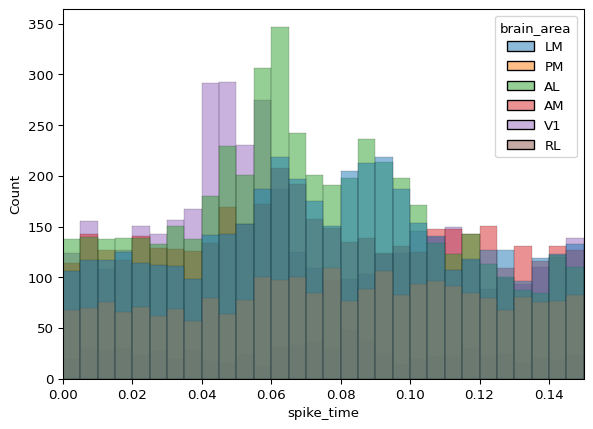

In [22]:
sns.histplot(df, x="spike_time", hue="brain_area", bins=300)
plt.xlim(0, 0.15)

## 3 Counting Spikes in Discrete Bins

Seaborn’s `histplot` function gives us a quick and convenient way for
visualizing PSTHs. However, if we want to do further analyses on the
PSTHs we need to compute and store them ourselves. In this section, we
will explore how to divide our analysis into discrete bins and count the
number of spikes within each bin. The bin size in an important parameter
in many spiking analyses - if the bins are too small the resulting
signal will be noisy but if they are too wide we lose temporal
resolution.

| Code | Description |
|------------------------------------|------------------------------------|
| `bins = np.arange(start, stop, stepsize)` | Create an array of evenly spaced `bins` between `start` and `stop` with the given `stepsize` |
| `df.groupby("col1").col2.value_counts()` | Group the data by columns `"col1"` and get the `.value_counts()` of `"col2"` for each grouping |
| `df.groupby(["col1", "col2"]).col3.value_counts()` | Group the data by columns `"col1"` and `"col2"` and get the `.value_counts()` of `"col3"` for each grouping |
| `df.groupby("col1").col2.value_counts(bins=bins)` | Group the data by columns `"col1"` and get the `.value_counts()` of `"col2"` in the given `bins` |
| `df.col1.array.mid` | Get the midpoints for a series of time intervals |
| `df = df.reset_index()` | reset the index of `df` and store the old index in a new column |
| `df.columns = ["new1", "new2"]` | Rename the columns of `df` to `"new1"` and `"new2"` |
| `sns.lineplot(df, x="col1", y="col2", estimator="std")` | Plot the standard deviation of `"col1"` against `"col2"` |
| `sns.lineplot(df, x="col1", y="col2", hue="col3")` | Plot the values in `"col1"` against `"col2"` and add a `hue` based on `"col3"` |
| `sns.lineplot(df, x="col1", y="col2", units="col3", estimator=None)` | Plot the values in `"col1"` against `"col2"` separately for all `units` in `"col3"` |

------------------------------------------------------------------------

<span class="theorem-title">**Exercise 11**</span> Use `np.arange` to
create an array of evenly spaced bins between `0` and `1` seconds that
are `0.005` seconds wide. Print the number of bins in the array.

*Solution.*

In [24]:
bins = np.arange(0, 1, 0.005)
bins.shape

(200,)

<span class="theorem-title">**Example 2**</span> Group the `df` by
`"brain_area"` and get the `.value_counts()` of the `"spike_time"`.
Then, get the `.mid` of each interval and store it in the `"spike_time"`
column. Finally, rename the columns to `"bin_time"` and `"spike_count"`

In [26]:
psth = df.groupby(["brain_area"]).spike_time.value_counts(bins=bins).reset_index()
psth.spike_time = psth.spike_time.array.mid
psth.columns = ["brain_area", "bin_time", "spike_count"]
psth

1194 rows × 3 columns

<span class="theorem-title">**Exercise 12**</span> Create an
`sns.lineplot` to plot `y="spike_count"` across `x="bin_time"` (HINT: if
this takes too long, you can set `errorbar=None` to speed up
computation).

*Solution.*

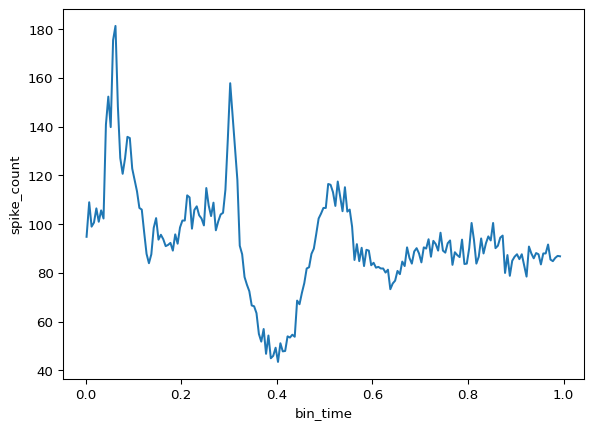

In [27]:
sns.lineplot(psth, x="bin_time", y="spike_count", errorbar=None)

<span class="theorem-title">**Exercise 13**</span> Use `sns.lineplot`
with `estimator="std"` to plot the standard deviation of the
`"spike_count"` across `"bin_time"`.

*Solution.*

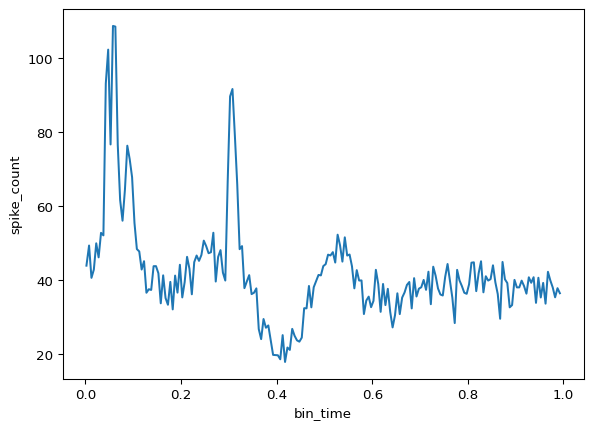

In [29]:
sns.lineplot(psth, x="bin_time", y="spike_count", errorbar=None, estimator="std")

<span class="theorem-title">**Exercise 14**</span> Create new `bins`
between `-0.2` and `0.8` seconds with a width of `0.025` seconds. Them
compute the `psth` as shown in
<a href="#exm-bin" class="quarto-xref">Example 2</a> and plot the
`"spike_count"` across `"bin_time"`.

*Solution.*

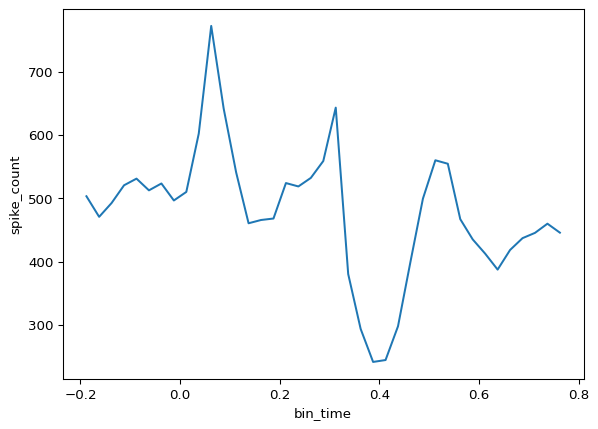

In [31]:
bins = np.arange(-0.2, 0.8, 0.025)
psth = df.groupby(["brain_area"]).spike_time.value_counts(bins=bins).reset_index()
psth.spike_time = psth.spike_time.array.mid
psth.columns = ["brain_area", "bin_time", "spike_count"]
sns.lineplot(psth, x="bin_time", y="spike_count", errorbar=None)

<span class="theorem-title">**Exercise 15**</span> Reduce the bin width
to a value that you think is appropriate, then re-compute the `psth` and
plot it again.

*Solution.*

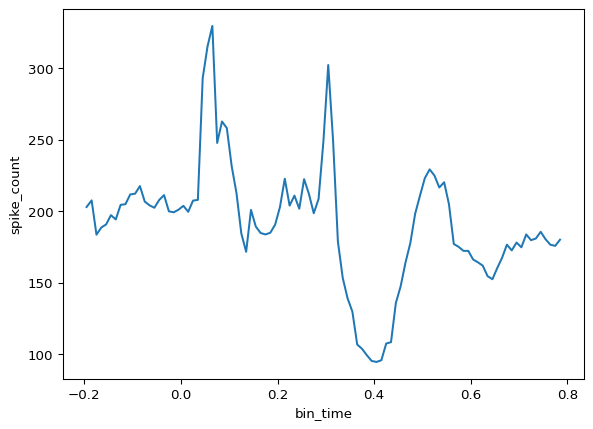

In [33]:
bins = np.arange(-0.2, 0.8, 0.01)
psth = df.groupby(["brain_area"]).spike_time.value_counts(bins=bins).reset_index()
psth.spike_time = psth.spike_time.array.mid
psth.columns = ["brain_area", "bin_time", "spike_count"]
sns.lineplot(psth, x="bin_time", y="spike_count", errorbar=None)

<span class="theorem-title">**Exercise 16**</span> Use `sns.lineplot` to
plot the PSTH for each brain_area separately by setting
`units="brain_area"` and `estimator=None`.

*Solution.*

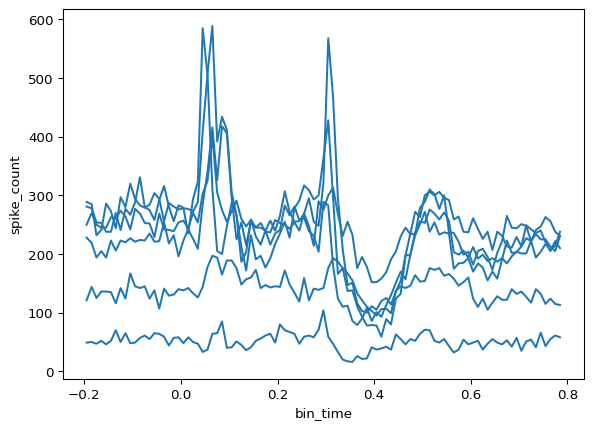

In [35]:
sns.lineplot(psth, x="bin_time", y="spike_count", errorbar=None, estimator=None, units="brain_area")

<span class="theorem-title">**Exercise 17**</span> Re-calculate the
`psth` as shown in <a href="#exm-bin" class="quarto-xref">Example 2</a>
but group the data by `"unit_id"` instead of `"brain_area"`. Then create
a `sns.lineplot` for every unit by setting `estimator=None` and
`units="unit_id"` (HINT: adjust the names of the `.columns`).

*Solution.*

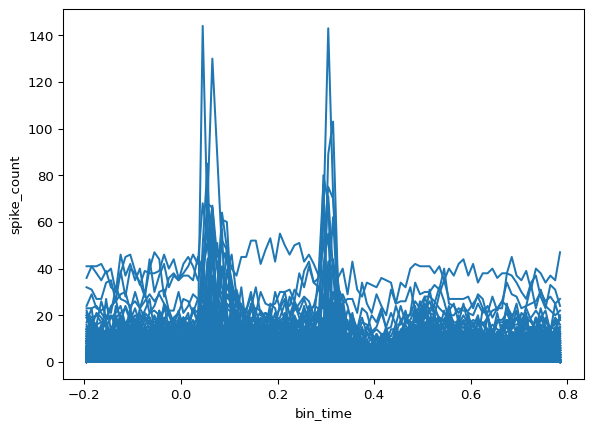

In [37]:
psth = df.groupby(["unit_id"]).spike_time.value_counts(bins=bins).reset_index()
psth.spike_time = psth.spike_time.array.mid
psth.columns = ["unit_id", "bin_time", "spike_count"]
sns.lineplot(
    psth, x="bin_time", y="spike_count", errorbar=None, estimator=None, units="unit_id"
)

<span class="theorem-title">**Exercise 18**</span> Re-calculate the
`psth` as shown in <a href="#exm-bin" class="quarto-xref">Example 2</a>
but group the data by `"unit_id"` AND `"brain_area"`. Then create a
`sns.lineplot` of the spike `"count"` across `"spike_time"` and add
`hue="brain_area"`.

*Solution.*

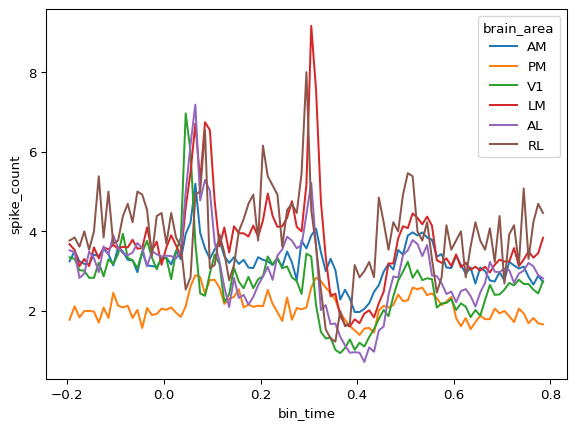

In [39]:
psth = (
    df.groupby(["unit_id", "brain_area"])
    .spike_time.value_counts(bins=bins)
    .reset_index()
)
psth.spike_time = psth.spike_time.array.mid
psth.columns = ["unit_id", "brain_area", "bin_time", "spike_count"]
sns.lineplot(psth, x="bin_time", y="spike_count", errorbar=None, hue="brain_area")

## 4 Comparing Firing Rates to a Baseline

In the previous plot, we saw that there is a large variability in the
baseline firing rate between brain areas and units. This makes
visualizations and statistical comparisons difficult. A common way of
dealing with this is to apply a baseline correction. For this, we select
a time interval and subtract the average spike count within this
interval from the rest of the signal. The resulting PSTH represents the
change in spiking relative to the baseline. In this section, we will
learn how to select baseline intervals, compute the baseline spiking
rate and correct the PSTHs.

| Code | Description |
|------------------------------------|------------------------------------|
| `mask = df.col1 < 1` | Create a boolean `mask` that is `True` where the column `"col1"` is smaller than `1` |
| `mask = (df.col1 < 1) & (df.col1 > 0)` | Create a boolean `mask` that is `True` where the column `"col1"` is smaller than `1` and larger than `0` |
| `df[mask]` | Get all rows of `df` where the `mask` is `True` |
| `df["newcol"] = values` | Create a new column in `df` called `"newcol"` and assign it the `values` |
| `del df["col1"]` | Delete `"col1"` from `df` |
| `df1.merge(df2, on="col1")` | Merge the data frames `df1` and `df2` based on the colum `"col1"` |
| `grouping = df.groupby(["col1"]).col2.mean()` | Group `df` by `"col1"` and get the mean value of `"col2"` for each grouping |
| `sns.histplot(grouping)` | Plot the `grouping` as a histogram |
| `sns.lineplot(psth, x="col1", y="col2", hue="col3")` | Plot `"col2"` against `"col1"` and add a `hue` for `"col3"` |

------------------------------------------------------------------------

<span class="theorem-title">**Example 3**</span> Compute the `baseline`
spike count for every `"unit_id"` in the time interval between
`tmin=-0.1` and `tmax=0` seconds.

In [41]:
tmin = -0.1
tmax = 0
mask = (psth.bin_time >= tmin) & (psth.bin_time <= tmax)
baseline = psth[mask].groupby(["unit_id"]).spike_count.mean()
baseline

unit_id
951015628    0.2
951015643    0.0
951015704    0.0
951015717    1.6
951015731    0.0
            ... 
951039462    2.7
951039560    0.4
951039854    0.2
951039863    0.2
951039870    8.1
Name: spike_count, Length: 386, dtype: float64

<span class="theorem-title">**Exercise 19**</span> Create a
`sns.histplot` to visualize the distribution of the `baseline` spike
count.

*Solution.*

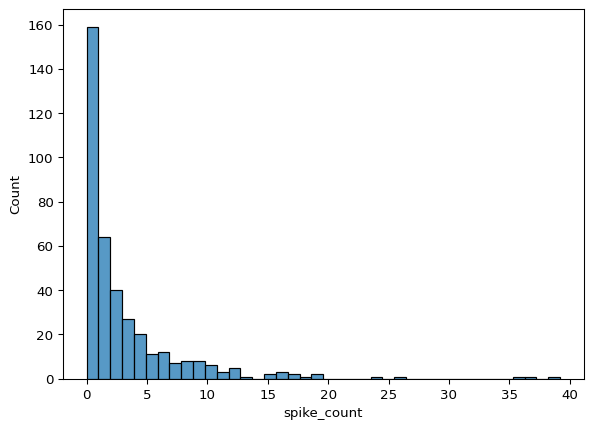

In [42]:
sns.histplot(baseline)

<span class="theorem-title">**Example 4**</span> `.merge()` the
`baseline` into the `psth` data frame based on the column `"unit_id"`.
Rename it to avoid naming conflicts.

In [44]:
baseline.name = "baseline"
psth = psth.merge(baseline, on="unit_id")
psth

38214 rows × 5 columns

<span class="theorem-title">**Exercise 20**</span> Subtract the
`"baseline"` from the `"spike_count"` and write the result to a new
column called `"baselined_spike_count"`.

*Solution.*

In [46]:
psth["baselined_spike_count"] = psth.spike_count - psth.baseline

<span class="theorem-title">**Exercise 21**</span> Create an
`sns.lineplot` of the `"baselined_spike_count"` across `"time"` (HINT:
if this takes too long set `errorbar=None` to speed up computation).

*Solution.*

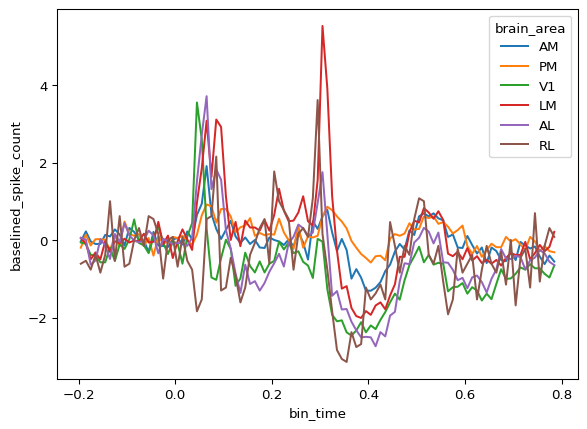

In [48]:
sns.lineplot(
    psth, x="bin_time", y="baselined_spike_count", hue="brain_area", errorbar=None
)

<span class="theorem-title">**Exercise 22**</span> Re-compute the
`baseline` as shown in
<a href="#exm-baseline" class="quarto-xref">Example 3</a> but use the
time interval from `tmin=0` to `tmax=0.1`. Then, visualize the
`baseline` with a `sns.histplot`.

*Solution.*

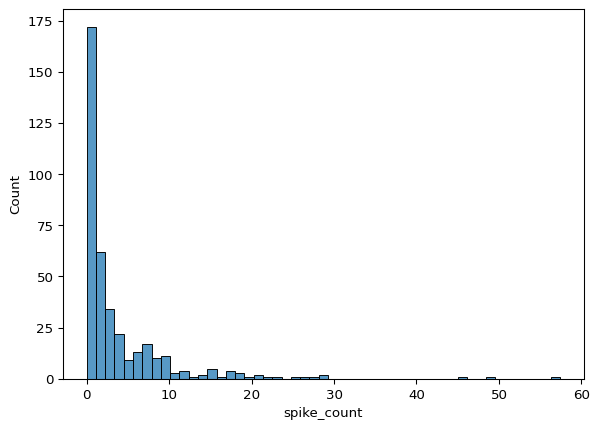

In [50]:
tmin = 0
tmax = 0.1
mask = (psth.bin_time >= tmin) & (psth.bin_time <= tmax)
baseline = psth[mask].groupby(["unit_id"]).spike_count.mean()
sns.histplot(baseline)

<span class="theorem-title">**Exercise 23**</span> Delete the existing
`"baseline"` column runnign the code below, then `.merge()` the new
`baseline` with `psth` as shown in @emx-merge. Subtract the `.baseline`
from the `.spike_count` and plot the resulting
`"baselined_spike_count"`. Was this baseline interval a good choice?

In [52]:
del psth["baseline"]

*Solution.*

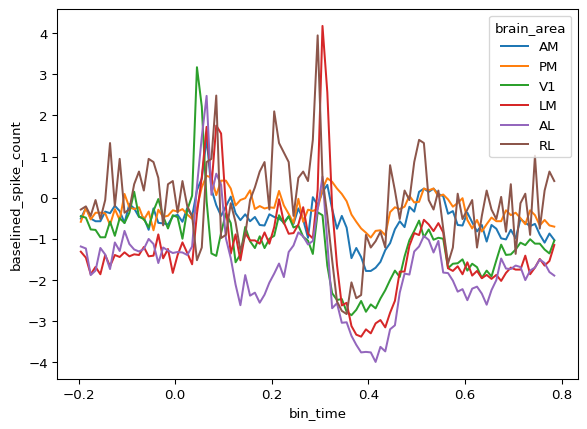

In [53]:
baseline.name = "baseline"
psth = psth.merge(baseline, on="unit_id")
psth["baselined_spike_count"] = psth.spike_count - psth.baseline
sns.lineplot(
    psth, x="bin_time", y="baselined_spike_count", hue="brain_area", errorbar=None
)

<span class="theorem-title">**Exercise 24**</span> Delete the existing
`"baseline"` column , then re-compute it using the time interval from
`tmin=-0.2` to `tmax=0`, `.merge()` it with the `psth` data frame, then
compute and plot the \`“baselined_spike_count”

*Solution.*

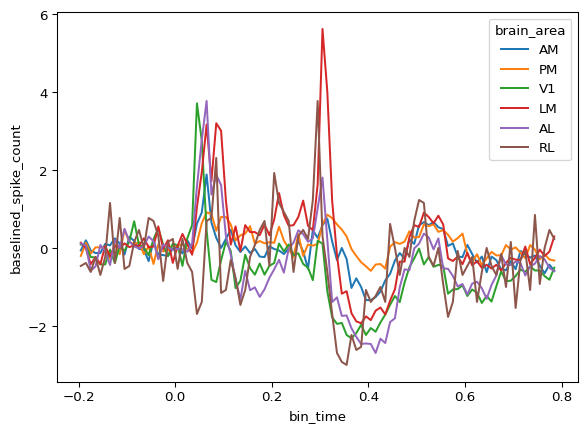

In [55]:
del psth["baseline"]
tmin = -0.2
tmax = 0
mask = (psth.bin_time >= tmin) & (psth.bin_time <= tmax)
baseline = psth[mask].groupby(["unit_id"]).spike_count.mean()
baseline.name = "baseline"
psth = psth.merge(baseline, on="unit_id")
psth["baselined_spike_count"] = psth.spike_count - psth.baseline
sns.lineplot(
    psth, x="bin_time", y="baselined_spike_count", hue="brain_area", errorbar=None
)

<span class="theorem-title">**Exercise 25**</span> Plot the
`"baselined_spike_counts"` cross `"bin_time"` with a `hue` for
`"brain_area"` but plot every `"unit_id"` as individual `units`.

*Solution.*

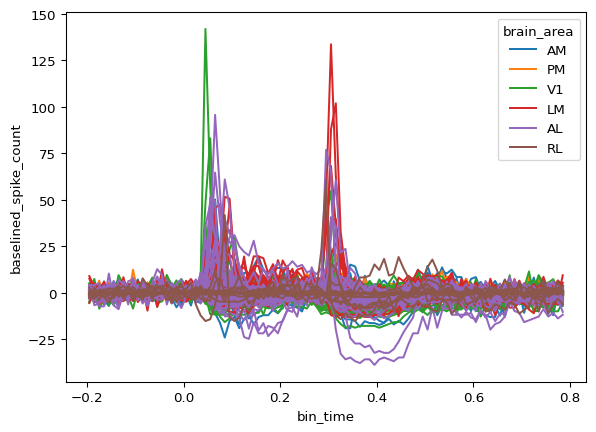

In [57]:
sns.lineplot(
    psth, x="bin_time", y="baselined_spike_count", hue="brain_area", errorbar=None, units="unit_id", estimator=None
)

## 5 Identifying Responsive Units

The last plot clearly showed that not all units respond to the stimulus
by spiking. Some do not respond at all while others decrease their
firing rate below the baseline. This can be problematic if we want to
average the PSTHs to estimate the response of larger populations of
neurons. To avoid distorting our average, we have to identify which
units are responsive. For this purpose, we’ll normalize the PSTHs by
applying the formular

$$
psth_{normalized} = \frac{psth-baseline}{baseline+\epsilon}
$$

The normalized PSTH describes the firing of a neuron relative to the
baseline. The regularization coefficient $\epsilon$ is a small number
that is added to the baseline to avoid errors for units with a baseline
rate close to 0. Based on the normalized PSTH, we can define a threshold
(e.g. 2 times the baseline rate) and categorize each unit above this
threshold as responsive. In this section, you’ll explore normalizing the
PSTHs while applying different values of $\epsilon$ and selection
thresholds.

| Code | Description |
|------------------------------------|------------------------------------|
| `grouping = df.groupby("col1").col2.max()` | Group `df` by `"col1"` and get the `.max()` of `"col2"` for each grouping |
| `mask = grouping > x` | Create a `mask` that is `True` where `grouping` is greater than `x` |
| `grouping.reset_index(name="new")` | Reset the index of `grouping` and store the old index in a new column under the `name="new"` |
| `df1.merge(df2, on=["col1", "col2"])` | Merge `df2` to `df1` based `on` the columns `"col1"` and `"col2"` |
| `sns.histplot(grouping)` | Plot a histogram of the values in `grouping` |
| `sns.barplot(df, x="col1", hue="col2")` | Create a bar plot for the values in `"col1"` for each value in `"col2"` |
| `plt.axvline(x, ymin, ymax)` | Add a vertical line at `x` that goes from `ymin` to `ymax` |

------------------------------------------------------------------------

<span class="theorem-title">**Exercise 26**</span> Compute the spike
count relative to the baseline by subtracting the `"baseline"` from the
`"spike_count"` and dividing the result by the `"baseline"`.

*Solution.*

In [59]:
psth["relative_spiking"] = (psth.spike_count - psth.baseline) / psth.baseline
psth

38214 rows × 7 columns

<span class="theorem-title">**Exercise 27**</span> Create a
`sns.lineplot` with `estimator=None` and `units="unit_id"` to plot the
`"relative_spiking"` for every unit.

*Solution.*

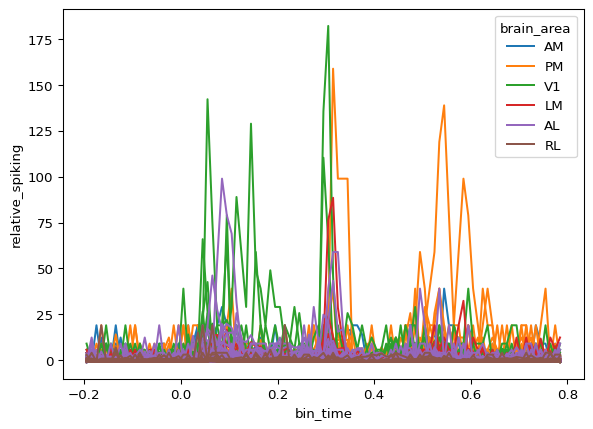

In [61]:
sns.lineplot(
    psth,
    x="bin_time",
    y="relative_spiking",
    hue="brain_area",
    units="unit_id",
    estimator=None,
)

<span class="theorem-title">**Exercise 28**</span> Re-compute the
`"relative_spiking"` but add the regularization parameter `epsilon` to
the baseline before dividing to avoid distorting the responses of units
with a very low baseline. Then, plot the `"relative_spiking"` across
`"bin_time"` for each `"unit_id"`.

In [63]:
epsilon = 0.2

*Solution.*

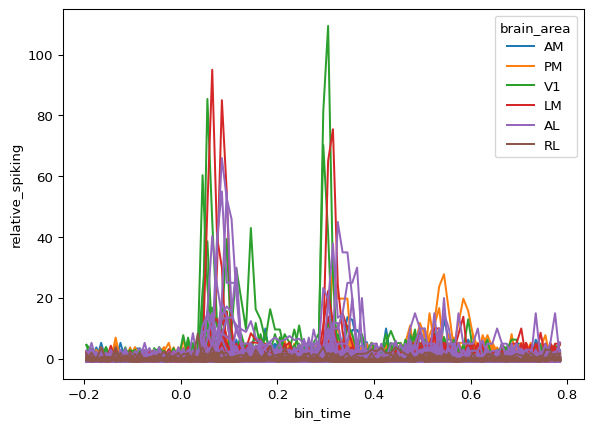

In [64]:
psth["relative_spiking"] = (psth.spike_count - psth.baseline) / (
    psth.baseline + epsilon
)
sns.lineplot(
    psth,
    x="bin_time",
    y="relative_spiking",
    hue="brain_area",
    units="unit_id",
    estimator=None,
)

<span class="theorem-title">**Exercise 29**</span> Increase the value of
`epsilion`, then re-compute the the values of the `"relative_spiking"`
and plot them to see the effect of the regularization parameter.

*Solution.*

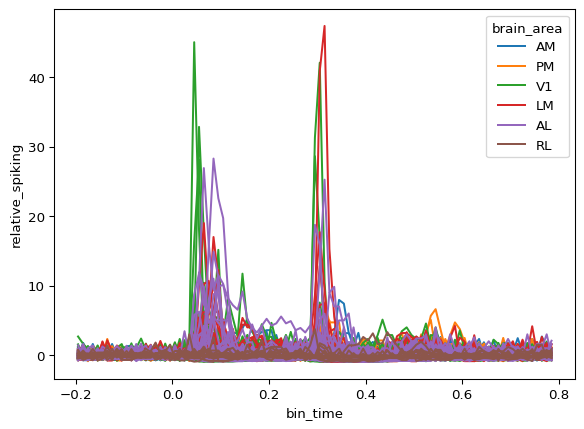

In [66]:
epsilon = 1
psth["relative_spiking"] = (psth.spike_count - psth.baseline) / (
    psth.baseline + epsilon
)
psth
sns.lineplot(
    psth,
    x="bin_time",
    y="relative_spiking",
    hue="brain_area",
    units="unit_id",
    estimator=None,
)

<span class="theorem-title">**Exercise 30**</span> Group the PSTHs by
the `"unit_id"` and compute the `.max()` of the `"relative_spiking"` for
each unit. Plot them in a histogram and draw a `plt.axvline` at the
`threshold` defined below.

In [68]:
threshold = 1.5

*Solution.*

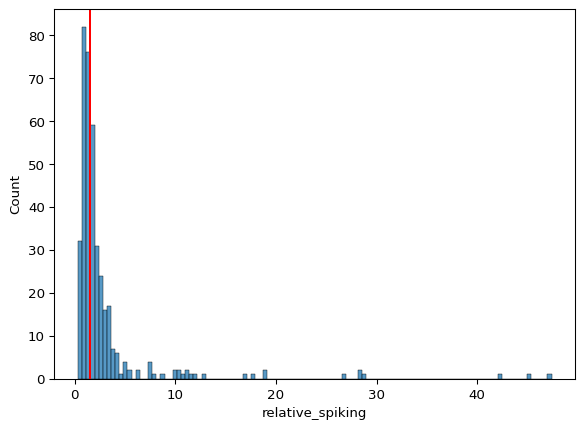

In [69]:
sns.histplot(psth.groupby("unit_id").relative_spiking.max())
plt.axvline(x=threshold, ymin=0, ymax=1, color="red")

<span class="theorem-title">**Example 5**</span> Group the psth by
`"unit_id"` and `"brain_area"` and compare the `.max()` of the
`"relative_spiking"` to the `threshold` to determine if a unit
`"is_responsive"`. Then, reset the index of `is_responsive` and name the
new column `"is_responsive"`

In [71]:
is_responsive = psth.groupby(["unit_id", "brain_area"]).relative_spiking.max() > threshold
is_responsive = is_responsive.reset_index(name="is_responsive")
is_responsive

386 rows × 3 columns

<span class="theorem-title">**Exercise 31**</span> Create a
`sns.barplot` with `x="is_responsive"` and `hue="brain_area"` to
visualize the fraction of units in each area that responds to the
stimulus according to the `threshold` criterion.

*Solution.*

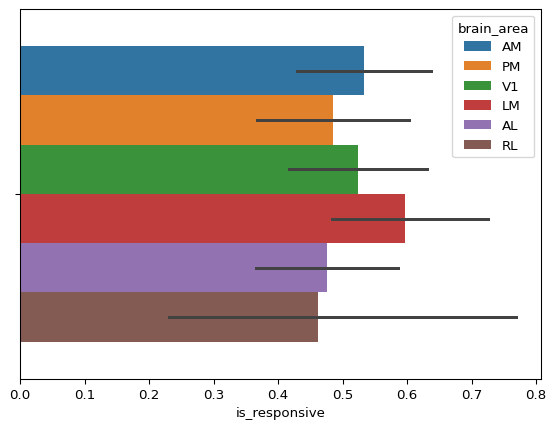

In [72]:
sns.barplot(is_responsive, x="is_responsive", hue="brain_area")

<span class="theorem-title">**Exercise 32**</span> Try a different
`threshold` value, and plot a `sns.histplot` of the unit’s maximum
`"relative_firing"` together with the threshold to check how many units
would be rejected by the threshold. Then re-compute the responsive units
as shown in <a href="#exm-resp" class="quarto-xref">Example 5</a> and
plot the fraction of responsive units per area.

*Solution.*

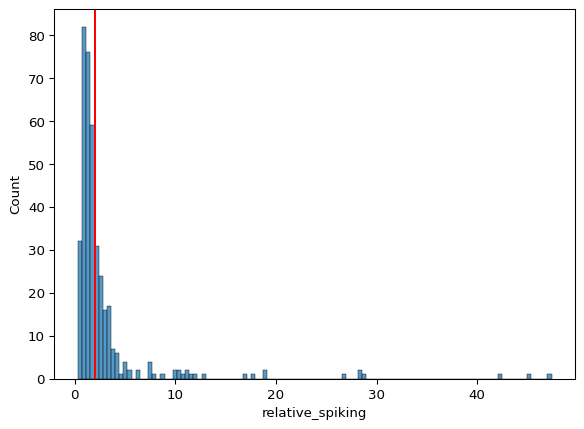

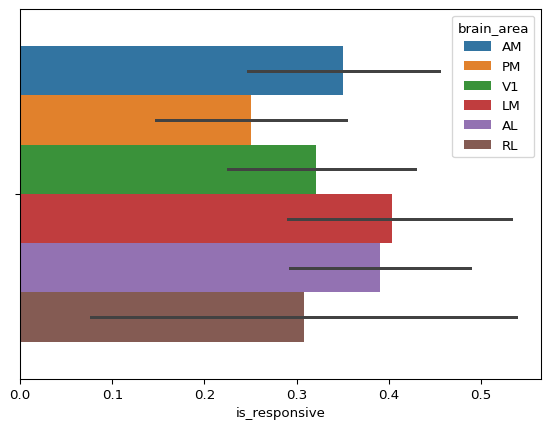

In [74]:
threshold = 2
sns.histplot(psth.groupby("unit_id").relative_spiking.max())
plt.axvline(x=threshold, ymin=0, ymax=1, color="red")
plt.figure()
is_responsive = (
    psth.groupby(["unit_id", "brain_area"]).relative_spiking.max() > threshold
)
is_responsive = is_responsive.reset_index(name="is_responsive")
sns.barplot(is_responsive, x="is_responsive", hue="brain_area")

<span class="theorem-title">**Exercise 33**</span> Merge the
`is_responsive` data frame into the `psth` data frame with
`on=["unit_id", "brain_area"]`.

*Solution.*

In [76]:
psth = psth.merge(is_responsive, on=["unit_id", "brain_area"])

<span class="theorem-title">**Exercise 34**</span> Select only the units
that are responsive (`psth[psth.is_responsive]`) and plot their
`"baselined_spike_count"` across `"bin_time"` for each brain area.

*Solution.*

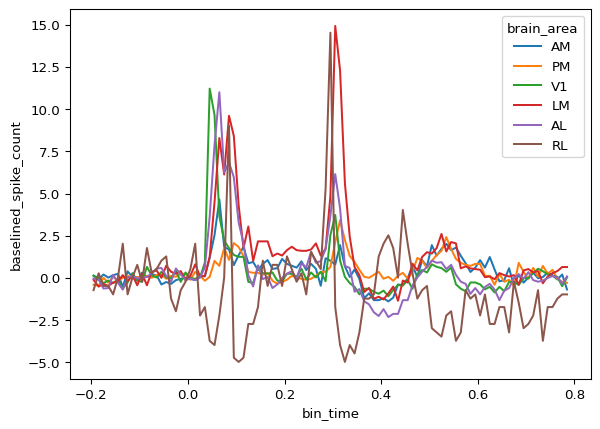

In [78]:
sns.lineplot(
    psth[psth.is_responsive],
    x="bin_time",
    y="baselined_spike_count",
    hue="brain_area",
    errorbar=None,
)

<span class="theorem-title">**Exercise 35**</span> Plot the PSTH of the
responsive units for each individual `"unit_id"`.

*Solution.*

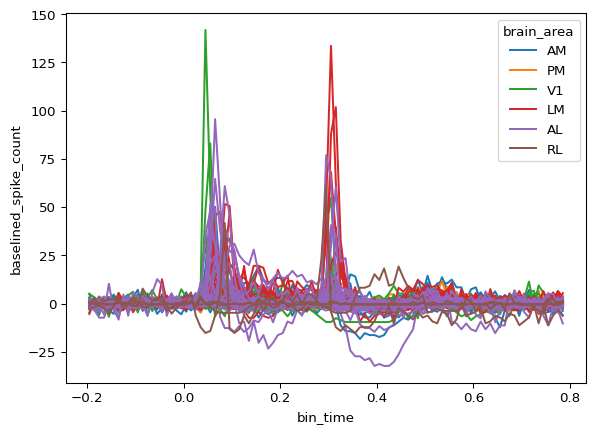

In [80]:
sns.lineplot(
    psth[psth.is_responsive],
    x="bin_time",
    y="baselined_spike_count",
    hue="brain_area",
    estimator=None,
    units="unit_id",
    errorbar=None,
)